## JobSkape 

<div style="align-items:center; justify-content:center">
    <img src="static/jobskape.png" style="width:1000px"/>
</div>

In [9]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from generator import (
    SkillsGenerator,
    DatasetGenerator
)
from tqdm.notebook import tqdm
from transformers import (
    AutoModel,
    AutoTokenizer
)
import pickle

import os
API_KEY = os.environ["API_KEY"]

if(API_KEY == ""):
    raise NotImplementedError("You need to enter your OPENAI API key in .env")


tqdm.pandas()


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
## Loading the embedded taxonomy
ESCO_DIR = "./taxonomy/"

with open(ESCO_DIR + "dev_skillspan_emb.pkl", "rb") as f:
    dev_emb_tax = pickle.load(f)
    dev_emb_tax["embeddings"] = dev_emb_tax["embeddings"].apply(lambda x : x.detach())

with open(ESCO_DIR + "test_skillspan_emb.pkl", "rb") as f:
    test_emb_tax = pickle.load(f)
    test_emb_tax["embeddings"] = test_emb_tax["embeddings"].apply(lambda x : x.detach())

## create train emb tax
train_emb_tax = pd.concat([test_emb_tax, dev_emb_tax]).drop_duplicates("name")


## get taxonomy without embeddings
dev_tax = dev_emb_tax.drop("embeddings", axis=1)
test_tax = test_emb_tax.drop("embeddings", axis=1)
train_tax = train_emb_tax.drop("embeddings", axis=1)


## popularity distribution
F = pd.read_csv("utils/ppl_3_sentences_all_skills.csv")\
        .drop("Unnamed: 0", axis=1)[["name", "mean_std_ppl"]]\
        .set_index("name")\
        .to_dict()["mean_std_ppl"]

## skill nb distribution
MAX_NB_SKILL = 5
combination_dist = np.ones(MAX_NB_SKILL) / MAX_NB_SKILL

## Models
word_emb = "jjzha/jobbert-base-cased"
word_emb_model = AutoModel.from_pretrained(word_emb)
word_emb_tokenizer = AutoTokenizer.from_pretrained(word_emb)

## Not used in this version
additional_info = None


Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Skill Generator

In [11]:
def combinations_generation(emb_tax, split_size):
    gen = SkillsGenerator(taxonomy=emb_tax, 
                taxonomy_is_embedded=True,
                combination_dist=combination_dist,
                popularity=F)
    
    gen_args = {
        "nb_generation" : split_size, # number of samples
        "threshold" : 0.83, # not considering skills that are less than .8 similar
        "beam_size" : 20, # considering 20 skills
        "temperature_pairing": 1, # popularity to be skewed toward popular skills
        "temperature_sample_size": 1,
        "frequency_select": True, # wether we select within the NN acording to frequency
    }


    combinations = list(gen.balanced_nbred_iter(**gen_args))
    return combinations

split_sizes = {
    "train": 0.75,
    "test": 0.15,
    "dev": 0.15,
}
split_emb_taxs = {
    "train": train_emb_tax,
    "test": test_emb_tax,
    "dev": dev_emb_tax,
}

TOTAL_SAMPLES = 8_000

combinations = {}
for split in split_sizes:
    combinations[split] = combinations_generation(split_emb_taxs[split], int(TOTAL_SAMPLES * split_sizes[split]))

Number of combinations in train split : 6000
Number of combinations in test split : 1200
Number of combinations in dev split : 1200


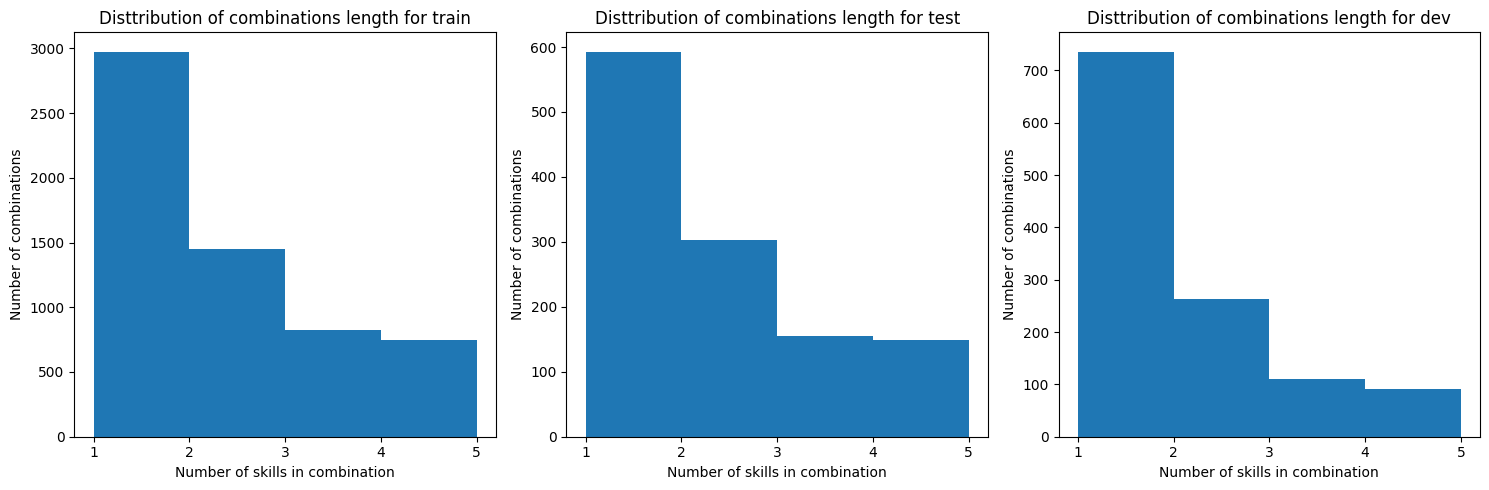

In [12]:
f, a = plt.subplots(1, 3, figsize=(15, 5))

for ax, split in zip(a.flatten(), split_sizes):
    combinations[split] = combinations_generation(split_emb_taxs[split], int(TOTAL_SAMPLES * split_sizes[split]))
    ax.hist([len(x) for x in combinations[split]], bins=np.arange(1,6))
    ax.set_title(f"Disttribution of combinations length for {split}")
    ax.set_ylabel("Number of combinations")
    ax.set_xlabel("Number of skills in combination")
    ax.set_xticks(np.arange(1,6))
    print(f"Number of combinations in {split} split : {len(combinations[split])}")

plt.tight_layout()

### Sentence generator

In [13]:
def generate_split(split, n_samples=None):
    combs = combinations[split]

    if(n_samples is None):
        n_samples = len(combs)
    
    emb_tax = split_emb_taxs[split]
    datagen = DatasetGenerator(emb_tax,
                           None, ## no references, we work in Zero-Shot
                           word_emb_model,
                           word_emb_tokenizer,
                           additional_info)

    generation_args = {
        "skill_generator": combs[:n_samples], 
        "specific_few_shots": False,
        "model": "gpt-3.5",
        "gen_mode": "PROTOTYPE",
        "autosave": True,
        "autosave_file": f"generated/SKILLSPAN/{split}.json",
        "checkpoints_freq":10
    }
    res = datagen.generate_ds(**generation_args)
    return res
    
    

In [14]:
res = generate_split("train", n_samples=10)

0it [00:00, ?it/s]

In [16]:
for r in res:
    print("-"*100)
    print("labels :", r[0])
    print("sentence : ")
    [print(r[1][n:n+75]) for n in range(0, len(r[1]), 75)]

----------------------------------------------------------------------------------------------------
labels : ['pharmaceutical processes']
sentence : 
Experienced candidates with a deep understanding of the intricate procedure
s involved in the manufacturing and quality control of pharmaceutical produ
cts are strongly encouraged to apply.
----------------------------------------------------------------------------------------------------
labels : ['computer programming', 'MATLAB']
sentence : 
"Proficiency in scripting and coding languages widely used in scientific re
search, including expertise in MATLAB, is required to develop and maintain 
data analysis software and algorithms."
----------------------------------------------------------------------------------------------------
labels : ['service-oriented modelling', 'computer science', 'SaaS (service-oriented modelling)', 'object-oriented modelling', 'Open source model']
sentence : 
We are seeking a highly skilled and knowledgeable 

In [19]:
train_ds = generate_split("train")

0it [00:00, ?it/s]

> saved checkpoint at 10
> saved checkpoint at 20
> saved checkpoint at 30
> saved checkpoint at 40
> saved checkpoint at 50
> saved checkpoint at 60
> saved checkpoint at 70
> saved checkpoint at 80
> saved checkpoint at 90
> saved checkpoint at 100
> saved checkpoint at 110
> saved checkpoint at 120
> saved checkpoint at 130
> saved checkpoint at 140
> saved checkpoint at 150
> saved checkpoint at 160
> saved checkpoint at 170
> saved checkpoint at 180
> saved checkpoint at 190
> saved checkpoint at 200
> saved checkpoint at 210
> saved checkpoint at 220
> saved checkpoint at 230
> saved checkpoint at 240
> saved checkpoint at 250
> saved checkpoint at 260
> saved checkpoint at 270
> saved checkpoint at 280
> saved checkpoint at 290
> saved checkpoint at 300
> saved checkpoint at 310
> saved checkpoint at 320
> saved checkpoint at 330
> saved checkpoint at 340
> saved checkpoint at 350
> saved checkpoint at 360
> saved checkpoint at 370
> saved checkpoint at 380
> saved checkpoint at

In [11]:
test_ds = generate_split("test")

0it [00:00, ?it/s]

> saved checkpoint at 10
> saved checkpoint at 20
> saved checkpoint at 30
> saved checkpoint at 40
> saved checkpoint at 50
> saved checkpoint at 60
> saved checkpoint at 70
> saved checkpoint at 80
> saved checkpoint at 90
> saved checkpoint at 100
Timed out Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=20). Waiting for 10 seconds.
> saved checkpoint at 110
> saved checkpoint at 120
> saved checkpoint at 130
> saved checkpoint at 140
> saved checkpoint at 150
> saved checkpoint at 160
> saved checkpoint at 170
> saved checkpoint at 180
> saved checkpoint at 190
> saved checkpoint at 200
> saved checkpoint at 210
> saved checkpoint at 220
> saved checkpoint at 230
> saved checkpoint at 240
> saved checkpoint at 250
> saved checkpoint at 260
> saved checkpoint at 270
> saved checkpoint at 280
> saved checkpoint at 290
> saved checkpoint at 300
> saved checkpoint at 310
> saved checkpoint at 320
> saved checkpoint at 330
> saved c

In [14]:
dev_ds = generate_split("dev")

0it [00:00, ?it/s]

> saved checkpoint at 10
> saved checkpoint at 20
> saved checkpoint at 30
> saved checkpoint at 40
> saved checkpoint at 50
> saved checkpoint at 60
> saved checkpoint at 70
> saved checkpoint at 80
> saved checkpoint at 90
> saved checkpoint at 100
> saved checkpoint at 110
> saved checkpoint at 120
> saved checkpoint at 130
> saved checkpoint at 140
> saved checkpoint at 150
> saved checkpoint at 160
> saved checkpoint at 170
> saved checkpoint at 180
> saved checkpoint at 190
> saved checkpoint at 200
> saved checkpoint at 210
> saved checkpoint at 220
> saved checkpoint at 230
> saved checkpoint at 240
Timed out Rate limit reached for gpt-3.5-turbo in organization org-tUY6bwaZRR8IwltlIGVE2rVA on tokens per min (TPM): Limit 1000000, Used 999737, Requested 447. Please try again in 11ms. Visit https://platform.openai.com/account/rate-limits to learn more.. Waiting for 10 seconds.
> saved checkpoint at 250
> saved checkpoint at 260
> saved checkpoint at 270
> saved checkpoint at 280
>

### Negative samples 

In [18]:
no_label_gen = pd.read_csv("generated/PROTOTYPE/no_label_gen.csv").drop("Unnamed: 0", axis=1)
no_label_gen["skills"] = no_label_gen["skills"].apply(lambda x : [x])
no_label_gen.head(3)

,sentence,skills
0,Join our innovative tech company headquartered...,[NO LABEL]
1,Kick-start your career with a leading financia...,[NO LABEL]
2,Be part of a dynamic e-commerce giant headquar...,[NO LABEL]


In [23]:
from sklearn.model_selection import train_test_split

no_label_train, no_label_rest = train_test_split(no_label_gen, test_size=int(.3 * len(no_label_gen.index)))
no_label_test, no_label_dev = train_test_split(no_label_rest, test_size=int(.5 * len(no_label_rest.index)))

print("NO LABEL TRAIN : ", len(no_label_train.index))
print("NO LABEL TEST : ", len(no_label_test.index))
print("NO LABEL DEV : ", len(no_label_dev.index))

assert(set(no_label_train["sentence"].values).intersection(no_label_test["sentence"].values) == set())
assert(set(no_label_dev["sentence"].values).intersection(no_label_test["sentence"].values) == set())
assert(set(no_label_train["sentence"].values).intersection(no_label_dev["sentence"].values) == set())

NO LABEL TRAIN :  341
NO LABEL TEST :  73
NO LABEL DEV :  72


In [41]:
no_label_split = {
    'train': no_label_train,
    'dev': no_label_dev,
    'test': no_label_test,

}
def merge(split):
    print("> SPLIT : ", split)
    no_label = no_label_split[split][["sentence", "skills"]]
    with open(f"generated/SKILLSPAN/{split}.pkl", 'rb') as f:
        complete_split = pickle.load(f)
    df_split = pd.DataFrame(complete_split)
    df_split.columns = ["skills", "sentence"]
    print("Number of sample before : ", len(df_split.index))
    df_split_complete = pd.concat([df_split, no_label])
    df_split_complete = df_split_complete.sample(len(df_split_complete.index))
    print("Number of sample after : ", len(df_split_complete.index))
    df_split_complete.to_csv(f"generated/SKILLSPAN/{split}_complete.csv")
    
merge("train")
merge("test")
merge("dev")

> SPLIT :  train
Number of sample before :  5724
Number of sample after :  6065
> SPLIT :  test
Number of sample before :  1144
Number of sample after :  1217
> SPLIT :  dev
Number of sample before :  1183
Number of sample after :  1255


### Adding excluded samples

In [42]:
with open(ESCO_DIR + "excluded_skill_span_tax_emb.pkl", "rb") as f:
    excluded_tax_sp = pickle.load(f).drop("Unnamed: 0", axis=1)
excluded_tax_sp.head(3)

,Source,Type Level 4,altLabels,Definition,Dimension,Type Level 1,Type Level 2,Type Level 3,unique_id,name,name+definition,embeddings
0,http://data.europa.eu/esco/skill/0005c151-5b5a...,manage musical staff,manage staff of music\ncoordinate duties of mu...,Assign and manage staff tasks in areas such as...,skills,management skills,supervising people,supervising a team or group,1000,manage musical staff,manage musical staff : assign and manage staff...,"[[tensor(0.3457), tensor(-0.5795), tensor(-0.0..."
1,http://data.europa.eu/esco/skill/00064735-8fad...,supervise correctional procedures,oversee prison procedures\nmanage correctional...,Supervise the operations of a correctional fac...,skills,management skills,"organising, planning and scheduling work and a...",directing operational activities,1001,supervise correctional procedures,supervise correctional procedures : supervise ...,"[[tensor(0.0875), tensor(-0.5299), tensor(-0.1..."
2,http://data.europa.eu/esco/skill/000709ed-2be5...,apply anti-oppressive practices,apply non-oppressive practices\napply an anti-...,"Identify oppression in societies, economies, c...",skills,assisting and caring,protecting and enforcing,protecting and enforcing,1002,apply anti-oppressive practices,apply anti-oppressive practices : identify opp...,"[[tensor(0.9495), tensor(-0.7187), tensor(-0.5..."


In [44]:
gen = SkillsGenerator(taxonomy=excluded_tax_sp, 
                taxonomy_is_embedded=True,
                combination_dist=combination_dist,
                popularity=F)
    
gen_args = {
        "nb_generation" : 500, # number of samples
        "threshold" : 0.83, # not considering skills that are less than .8 similar
        "beam_size" : 20, # considering 20 skills
        "temperature_pairing": 1, # popularity to be skewed toward popular skills
        "temperature_sample_size": 1,
        "frequency_select": True, # wether we select within the NN acording to frequency
    }


combinations = list(gen.balanced_nbred_iter(**gen_args))


datagen = DatasetGenerator(excluded_tax_sp,
                           None, ## no references, we work in Zero-Shot
                           word_emb_model,
                           word_emb_tokenizer,
                           additional_info)

generation_args = {
        "skill_generator": combinations, 
        "specific_few_shots": False,
        "model": "gpt-3.5",
        "gen_mode": "PROTOTYPE",
        "autosave": True,
        "autosave_file": f"generated/SKILLSPAN/excluded_tax_samples.json",
        "checkpoints_freq":10
    }
res = datagen.generate_ds(**generation_args)

0it [00:00, ?it/s]

> saved checkpoint at 10
> saved checkpoint at 20
> saved checkpoint at 30
> saved checkpoint at 40
> saved checkpoint at 50
> saved checkpoint at 60
> saved checkpoint at 70
> saved checkpoint at 80
> saved checkpoint at 90
> saved checkpoint at 100
> saved checkpoint at 110
> saved checkpoint at 120
> saved checkpoint at 130
> saved checkpoint at 140
> saved checkpoint at 150
> saved checkpoint at 160
> saved checkpoint at 170
> saved checkpoint at 180
> saved checkpoint at 190
> saved checkpoint at 200
> saved checkpoint at 210
> saved checkpoint at 220
> saved checkpoint at 230
> saved checkpoint at 240
> saved checkpoint at 250
> saved checkpoint at 260
> saved checkpoint at 270
> saved checkpoint at 280
> saved checkpoint at 290
> saved checkpoint at 300
> saved checkpoint at 310
> saved checkpoint at 320
> saved checkpoint at 330
> saved checkpoint at 340
> saved checkpoint at 350
> saved checkpoint at 360
> saved checkpoint at 370
> saved checkpoint at 380
> saved checkpoint at

In [62]:
ex_label = pd.DataFrame(res)
ex_label.columns = ["skills", "sentence"]
ex_label["skills"] = [["NO LABEL"]] * len(ex_label.index)
ex_label_train, ex_label_rest = train_test_split(ex_label, test_size=int(.3 * len(ex_label.index)))
ex_label_test, ex_label_dev = train_test_split(ex_label_rest, test_size=int(.5 * len(ex_label_rest.index)))

print("NO LABEL TRAIN : ", len(ex_label_train.index))
print("NO LABEL TEST : ", len(ex_label_test.index))
print("NO LABEL DEV : ", len(ex_label_dev.index))

assert(set(ex_label_train["sentence"].values).intersection(ex_label_test["sentence"].values) == set())
assert(set(ex_label_dev["sentence"].values).intersection(ex_label_test["sentence"].values) == set())
assert(set(ex_label_train["sentence"].values).intersection(ex_label_dev["sentence"].values) == set())


ex_label_split = {
    'train': ex_label_train,
    'dev': ex_label_dev,
    'test': ex_label_test,

}

def merge(split):
    print("> SPLIT : ", split)
    no_label = ex_label_split[split][["sentence", "skills"]]
    complete_split = pd.read_csv(f"generated/SKILLSPAN/{split}_complete.csv").drop("Unnamed: 0", axis=1)
    complete_split["skills"] = complete_split["skills"].apply(eval)
    df_split = pd.DataFrame(complete_split)
    df_split.columns = ["skills", "sentence"]
    print("Number of sample before : ", len(df_split.index))
    df_split_complete = pd.concat([df_split, no_label])
    df_split_complete = df_split_complete.sample(len(df_split_complete.index))
    print("Number of sample after : ", len(df_split_complete.index))
    df_split_complete.to_csv(f"generated/SKILLSPAN/{split}_final.csv", index=False)
    
merge("train")
merge("test")
merge("dev")

NO LABEL TRAIN :  299
NO LABEL TEST :  64
NO LABEL DEV :  64
> SPLIT :  train
Number of sample before :  6065
Number of sample after :  6364
> SPLIT :  test
Number of sample before :  1217
Number of sample after :  1281
> SPLIT :  dev
Number of sample before :  1255
Number of sample after :  1319
